In [111]:
import galsim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mido import MidiFile

In [116]:
def song_to_table(infile):
    """
    Takes a MIDI file (assume 2 tracks) and creates an input file
    for the make_galaxies() function and a time array
    """
    song = MidiFile(infile)
    
    t = 0
    notes, velo = np.array([], dtype=int), np.array([], dtype=int)
    abs_time, duration = np.array([], dtype=int), np.array([], dtype=int)
    for msg in song.tracks[1]:
        if msg.type == 'note_on':
            t += msg.time
            if msg.velocity > 0:
                notes = np.append(notes, msg.note)
                velo = np.append(velo, msg.velocity)
                abs_time = np.append(abs_time, t)
            elif notes.size:
                duration = np.append(duration, t - abs_time[notes==msg.note][-1])
    
    return np.vstack((notes,velo,duration)).T, abs_time

def make_galaxy(flux=1, Sersic_n=1, radius=4, q_shear=1, beta=0):
    """
    Makes an individual galaxy instance (convolved with a Gaussian PSF)
    """
    galaxy = galsim.Sersic(n=Sersic_n,scale_radius=radius,flux=flux)
    if q_shear < 1:
        galaxy = galaxy.shear(q=q_shear, beta=beta*galsim.degrees)
    psfObj = galsim.Gaussian(sigma=1)
    galConv = galsim.Convolve([psfObj,galaxy])
    
    return galConv

def makes_galaxies(inputs):
    """
    Takes the output of song_to_table(), and creates a list of galaxies
    """
    galList = []
    n_min, n_max = inputs.min(axis=0)[0], inputs.min(axis=0)[0]
    dur_fact = 240
    v_min = inputs.min(axis=0)[1]
    for note, vel, dur in inputs:
        v_scaled = vel / v_min
        n_scaled = 2.2 * (note-n_min) / (n_max-n_min) + 0.3
        d_scaled = dur / dur_fact
        gal = make_galaxy(flux=v_scaled, Sersic_n=n_scaled, radius=d_scaled)
        galList.append(gal)
    
    return galList

def map_time(time, img_x=4096, img_y=2160):
    """
    Maps the time of note hits to the image space
    """
    img_x, img_y = 4096, 2160
    offList = []
    time_scale = img_x * img_y / abs_time[-1]

    for time in abs_time:
        x = int((time * time_scale) % img_x - img_x/2)
        y = int((time * time_scale) // img_x - img_y/2)
        offList.append([x,y])
    
    return offList

def make_image(galaxy_list, offset_list, img_x=4096, img_y=2160, add_noise=True):
    """
    Takes a list of galaxy and a list of positions and creates an image
    """
    i = 0
    l = len(galaxy_list)
    for gal, offset in zip(galaxy_list, offset_list):
        if not i % 10: print(f"Working on galaxies: {i} of {l}", end='\r')
        gal_image = gal.drawImage(scale=1.,offset=offset,nx=img_x,ny=img_y)
        full_image = gal_image if i == 0 else full_image + gal_image
        i += 1
    print(f"Working on galaxies: {i} of {l}")
        
    if add_noise:
        noise = galsim.GaussianNoise(sigma=0.001)
        noise.applyTo(full_image)
        
    return full_image.array

def song_to_image(infile):
    """
    Runs everything at once
    """
    inputs, abs_time = song_to_table(infile)
    galList = makes_galaxies(inputs)
    offList = map_time(abs_time)
    image = make_image(galList, offList)
    return image

In [ ]:
img_arr = song_to_image('deb_clai.mid')

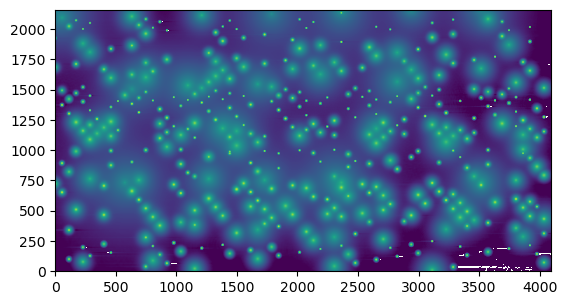

In [126]:
fig=plt.figure()
plt.imshow(img_arr, origin='lower', norm=LogNorm(img_arr.min(),img_arr.max()))
plt.axis('off')
fig.savefig('claire.png', bbox_inches='tight', pad_inches=0, dpi=826)
plt.show()